# Reinforcement Learning
_Oriol Bustos - May 2025_

## Imports

In [6]:
# %pip install pip install box2d-py
# %pip install --upgrade numpy
%pip install gymnasium[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.6 MB 4.8 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 5.5 MB/s eta 0:00:00
Failed to build box2d-py
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for box2d-py (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [29 lines of output]
      Using setuptools (version 80.4.0).
      C:\Users\oriol\AppData\Local\Temp\pip-build-env-syf28dab\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\oriol\AppData\Local\Temp\pip-build-env-syf28dab\overlay\Lib\site-packages\setuptools\dist.py:761: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: zlib/libpng License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              *

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import gym
import matplotlib.pyplot as plt


c:\Users\oriol\miniconda3\envs\gan_env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        # Shared feature layers
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        # Policy mean and value output layers
        self.policy_mean = nn.Linear(64, action_dim)
        self.value = nn.Linear(64, 1)
        # Log std for Gaussian policy (one per action dimension, initialized at 0.0)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
    def forward(self, state):
        # Shared layers forward pass
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        # Actor: output mean action, apply tanh to bound ([-1,1] action range)
        mean = torch.tanh(self.policy_mean(x))
        # Critic: output value
        value = self.value(x)
        return mean, value
    
    def get_action(self, state):
        """Sample an action from the policy for a given state, returning action and log-probability."""
        mean, value = self.forward(state)
        std = torch.exp(self.log_std)            # convert log_std param to std
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        # Clamp action to [-1,1] to respect action bounds
        action_clamped = torch.clamp(action, -1.0, 1.0)
        log_prob = dist.log_prob(action).sum(dim=-1)  # sum log_probs for multi-dimensional action
        return action_clamped.detach(), log_prob.detach(), value.detach()
    
    def evaluate_actions(self, states, actions):
        """Compute log-probabilities, values, and entropy for given states & actions (for training update)."""
        mean, values = self.forward(states)
        std = torch.exp(self.log_std)
        dist = torch.distributions.Normal(mean, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)     # entropy of Gaussian (sum across action dims)
        return log_probs, values.squeeze(-1), entropy


In [ ]:
env = gym.make("LunarLanderContinuous-v2")
state_dim = env.observation_space.shape[0]  # 8 state features
action_dim = env.action_space.shape[0]        # 2 continuous actions (main and side engines)
agent = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(agent.parameters(), lr=1e-4)

# ---- compatibility helpers made by chatgpt for Gym / Gymnasium API changes ----
def unwrap_reset(reset_out):
    """Return observation only, discarding the 'info' dict if present."""
    return reset_out[0] if isinstance(reset_out, tuple) else reset_out

def unwrap_step(step_out):
    """Return obs, reward, done, info in a version-agnostic way."""
    if len(step_out) == 5:                   # new API
        obs, reward, terminated, truncated, info = step_out
        done = terminated or truncated
        return obs, reward, done, info
    else:                                    # old API
        obs, reward, done, info = step_out
        return obs, reward, done, info
# ----------------------------------------------------------------



In [9]:
# PPO hyperparameters
gamma = 0.99
lam = 0.95
ppo_epochs = 10
batch_size = 128
clip_eps = 0.2
entropy_coef = 0.01
value_coef = 0.5

max_episodes = 300
goal_reward = 200  # solved when 100-episode avg > 200 (approximate threshold)

episode_rewards = []  # to track rewards per episode

for episode in range(1, max_episodes+1):
    state = unwrap_reset(env.reset())           
    done = False

    states = []
    actions = []
    log_probs = []
    rewards = []
    values = []
    
    # run one episode
    while not done:
        state_t = torch.FloatTensor(state).unsqueeze(0) 
        with torch.no_grad():
            action, log_prob, value = agent.get_action(state_t)

        # step
        # next_state_raw = env.step(action.squeeze(0).detach().cpu().numpy().tolist())
        next_state_raw = env.step(action.numpy()[0])
        next_state, reward, done, _ = unwrap_step(next_state_raw) 

        # store transition
        states.append(state)
        actions.append(action.numpy()[0])
        log_probs.append(log_prob.item())
        rewards.append(reward)
        values.append(value.item())
        # Move to next state
        state = next_state
    
    # Episode finished, record total reward
    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    
    # Compute value for terminal state (0 if done)
    if done:
        next_value = 0.0
    else:
        # (In this episodic setup, done will always be True at this point)
        next_state_t = torch.FloatTensor(next_state).unsqueeze(0)
        next_value = agent.forward(next_state_t)[1].item()
    
    # Compute advantages and returns using GAE
    advantages = []
    gae = 0.0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * (next_value if t == len(rewards)-1 else values[t+1]) - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    advantages = torch.FloatTensor(advantages)
    # Compute returns as value targets
    returns = advantages + torch.FloatTensor(values)
    
    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    # Convert list storages to tensors for update
    states_tensor = torch.FloatTensor(np.array(states))
    actions_tensor = torch.FloatTensor(np.array(actions))
    old_log_probs_tensor = torch.FloatTensor(np.array(log_probs))
    returns_tensor = returns.detach()
    advantages_tensor = advantages.detach()
    
    # PPO policy and value update
    for epoch in range(ppo_epochs):
        # We will perform mini-batch updates. Shuffle indices first:
        indices = np.arange(states_tensor.size(0))
        np.random.shuffle(indices)
        # Break into mini-batches
        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            mb_idx = indices[start:end]
            
            # Evaluate current policy on the mini-batch
            log_probs_new, values_new, entropy = agent.evaluate_actions(states_tensor[mb_idx], actions_tensor[mb_idx])
            # Calculate ratios for PPO clipping
            ratios = torch.exp(log_probs_new - old_log_probs_tensor[mb_idx])
            # Surrogate loss
            surr1 = ratios * advantages_tensor[mb_idx]
            surr2 = torch.clamp(ratios, 1.0 - clip_eps, 1.0 + clip_eps) * advantages_tensor[mb_idx]
            policy_loss = -torch.min(surr1, surr2).mean()
            # Value loss
            value_loss = value_coef * ((values_new - returns_tensor[mb_idx])**2).mean()
            # Entropy loss (we use a minus sign because we want to maximize entropy)
            entropy_loss = -entropy_coef * entropy.mean()
            # Total loss
            loss = policy_loss + value_loss + entropy_loss
            
            # Gradient descent step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # (Optional) print training progress
    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Last 10 avg: {avg_reward:.2f}")
        # Stop early if solved
        if avg_reward >= goal_reward:
            print("Environment solved, stopping early!")
            break

# Training completed
env.close()


AttributeError: 'ActorCritic' object has no attribute 'get_action'

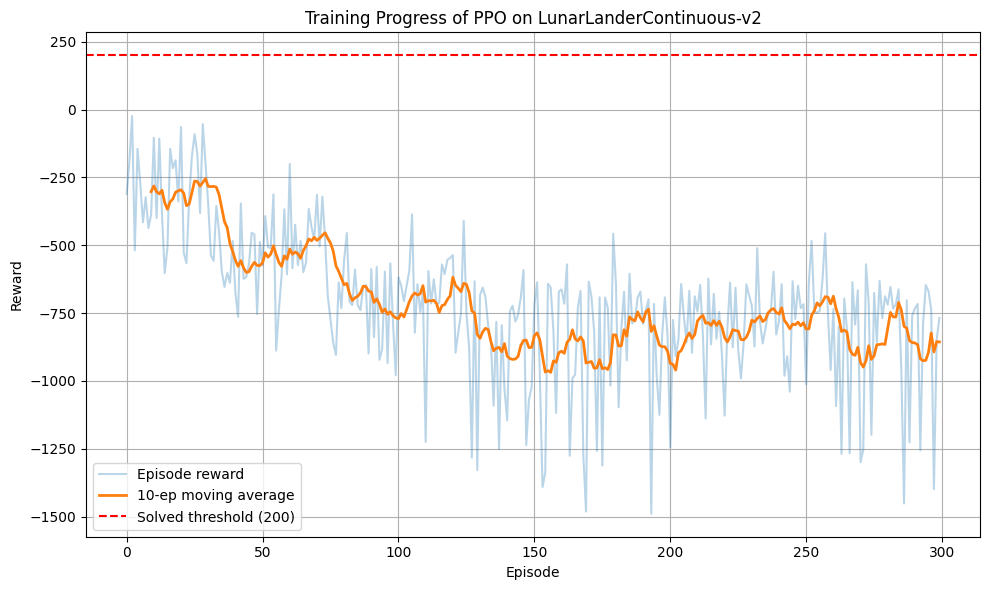

In [5]:

# Compute moving average (e.g. 10-episode window)
def moving_avg(x, window=10):
    return np.convolve(x, np.ones(window)/window, mode='valid')

rewards = np.array(episode_rewards)
avg_rewards = moving_avg(rewards)

plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Episode reward', alpha=0.3)
plt.plot(np.arange(len(avg_rewards)) + 10 - 1, avg_rewards, label='10-ep moving average', linewidth=2)
plt.axhline(200, color='red', linestyle='--', label='Solved threshold (200)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress of PPO on LunarLanderContinuous-v2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:

# Initialize the environment and the trained PPO agent (assuming it's already trained)
env = gym.make("LunarLanderContinuous-v2", render_mode="human")  # For Gym >= 0.26 or Gymnasium
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Assuming the existing ActorCritic class and the agent have been defined and trained
state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
done = False

# Run the environment and visualize it
for _ in range(1000):  # Run for a maximum of 1000 steps
    env.render()  # Render the environment to see the agent
    
    state_t = torch.FloatTensor(state).unsqueeze(0)  # Convert to tensor
    with torch.no_grad():
        action, _, _ = agent.get_action(state_t)  # Get action from trained agent

    next_step = env.step(action.numpy()[0])
    state = next_step[0] if len(next_step) == 5 else next_step[0]  # Handle Gym / Gymnasium
    done = next_step[2] if len(next_step) == 5 else next_step[2]

    if done:
        state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()

env.close()  # Close the environment when done.


KeyboardInterrupt: 